#IMPORT LIBRARY

Mengimport semua jenis library python yang akan digunakan dalam proses analisis ini.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

##HIPOTESIS NULL

H0: Tidak ada perbedaan signifikan dalam rata-rata durasi sesi antara pengguna yang menggunakan Antarmuka Versi A dan pengguna yang menggunakan Antarmuka Versi B.



##IMPORT AND UNDERSTANDING DATA

Mengimport dataset yang akan digunakan dalam proses analisis.

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/firson-creative/wc-datascience-finalproject/main/ab_testing_log.csv')
df.head(20)

##CHECK DATA QUALITY

Memeriksa kualitas data dari dataset untuk menentukan apakah data yang ada dapat langsung digunakan dan sesuai dengan tujuan analisis atau memerlukan pembersihan terlebih dahulu.

1. Pemeriksaan nilai hilang
2. Pemeriksaan tipe data
3. Pemeriksaan nilai unik pada kolom kategori

In [ ]:
print(df.isnull().sum())
df.info()

print(df['Interface_Group'].unique())
print(df['Interface_Group'].value_counts())
print(df['Device_Type'].unique())

#Explanasi

Pada Interface_Group ditemukan inkonsistensi dalam penamaan versi interface. Karena itu dataset ini perlu dirapikan dan distandarisasi sebelum digunakan. Selain hal tersebut, tidak ditemukan missing values pada kolom dataset ini.

##EXPLORING STATISTICS

Membaca ringkasan statistik deskriptif untuk kolom numerik dalam DataFrame, untuk memperoleh pemahaman awal tentang karakteristik numerik dataset, seperti rentang nilai, adanya outlier, dan seberapa homogen atau heterogen data tersebut.



In [ ]:
df.describe()

Memvisualisasikan sebaran atau distribusi durasi sesi di antara para pengguna dengan histogram.

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(df['Session_Duration_Minutes'], color='red')
plt.title('Distribusi Durasi Sesi - Sebelum dibersihkan')
plt.xlabel('Durasi Sesi (Menit)')
plt.ylabel('Frekuensi')
plt.savefig('hist.svg', format='svg')
plt.show()

#Eksplanasi
Sebagian besar pengguna cenderung memiliki durasi sesi yang relatif singkat. Ini adalah pola umum dalam banyak aplikasi atau situs web.

Terdapat sejumlah kecil pengguna yang sangat terlibat (atau mungkin meninggalkan aplikasi terbuka), yang menghasilkan durasi sesi yang sangat panjang, menciptakan 'ekor' pada distribusi (outlier). Hal ini menunjukkan variasi perilaku pengguna yang signifikan terkait dengan lamanya waktu yang dihabiskan di aplikasi. Namun karena tidak terlalu berpengaruh signifikan pada nilai mean pada distribusi, maka data tersebut (outlier) tidak dihapus/dihilangkan dari dataset.

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Interface_Group', y='Session_Duration_Minutes', data=df, errorbar=None)
plt.title('Rata-Rata Durasi Sesi Berdasarkan Interface Group - Sebelum dibersihkan')
plt.xlabel('Interface Group')
plt.ylabel('Average Session Duration (Minutes)')
plt.savefig('bar_before_cleaning.svg', format='svg')
plt.show()

##CLEANING DATA AND HANDLING ISSUES

Merapikan sistem penamaan versi interface menjadi,
- Versi A
- Versi B

untuk konsistensi dan standarisasi dalam penamaan.

In [ ]:
df['Interface_Group'] = df['Interface_Group'].replace({'A': 'Versi A', 'old_version': 'Versi A', 'control_group': 'Versi A', 'Version A': 'Versi A'})
df['Interface_Group'] = df['Interface_Group'].replace({'B': 'Versi B', 'Version B': 'Versi B', 'new_version': 'Versi B', 'test_group': 'Versi B'})

Menampilkan box plot Session_Duration_Minutes berdasarkan Interface_Group sebelum data dibersihkan untuk menemukan outliers.

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Interface_Group', y='Session_Duration_Minutes', data=df)
plt.title('Box Plot Durasi Sesi Berdasarkan Interface Group - Sebelum dibersihkan')
plt.xlabel('Interface Group')
plt.ylabel('Session Duration (Minutes)')
plt.savefig('boxplot_before_cleaning.svg', format='svg')
plt.show()

Identifikasi outliers pada data.

In [ ]:
durations_a = df[df['Interface_Group'] == 'Versi A']['Session_Duration_Minutes']

Q1_a = durations_a.quantile(0.25)
Q3_a = durations_a.quantile(0.75)
IQR_a = Q3_a - Q1_a

lower_bound_a = Q1_a - 1.5 * IQR_a
upper_bound_a = Q3_a + 1.5 * IQR_a

outlier_indices_a = df[(df['Interface_Group'] == 'Versi A') &
                        ((df['Session_Duration_Minutes'] < lower_bound_a) |
                         (df['Session_Duration_Minutes'] > upper_bound_a))].index

print(f"Q1 for Versi A: {Q1_a:.2f}")
print(f"Q3 for Versi A: {Q3_a:.2f}")
print(f"IQR for Versi A: {IQR_a:.2f}")
print(f"Lower Bound for Versi A: {lower_bound_a:.2f}")
print(f"Upper Bound for Versi A: {upper_bound_a:.2f}")
print(f"Outlier Indices for Versi A: {outlier_indices_a.tolist()}")

In [ ]:
durations_b = df[df['Interface_Group'] == 'Versi B']['Session_Duration_Minutes']

Q1_b = durations_b.quantile(0.25)
Q3_b = durations_b.quantile(0.75)
IQR_b = Q3_b - Q1_b

lower_bound_b = Q1_b - 1.5 * IQR_b
upper_bound_b = Q3_b + 1.5 * IQR_b

outlier_indices_b = df[(df['Interface_Group'] == 'Versi B') &
                        ((df['Session_Duration_Minutes'] < lower_bound_b) |
                         (df['Session_Duration_Minutes'] > upper_bound_b))].index

print(f"Q1 for Versi B: {Q1_b:.2f}")
print(f"Q3 for Versi B: {Q3_b:.2f}")
print(f"IQR for Versi B: {IQR_b:.2f}")
print(f"Lower Bound for Versi B: {lower_bound_b:.2f}")
print(f"Upper Bound for Versi B: {upper_bound_b:.2f}")
print(f"Outlier Indices for Versi B: {outlier_indices_b.tolist()}")

Membersihkan outliers dari data.

In [ ]:
all_outlier_indices = list(outlier_indices_a) + list(outlier_indices_b)
df_cleaned = df.drop(all_outlier_indices)

print(df_cleaned.shape)
print("\nFirst 5 rows of the cleaned DataFrame:")
print(df_cleaned.head())

Menyimpan data yang sudah dirapikan/distandarisasi dalam file baru dengan nama 'cleaned_ab_testing.csv'.

In [ ]:
df_cleaned.to_csv('cleaned_ab_testing_log.csv', index=False)
print('Dataset berhasil disimpan sebagai cleaned_ab_testing_log.csv')

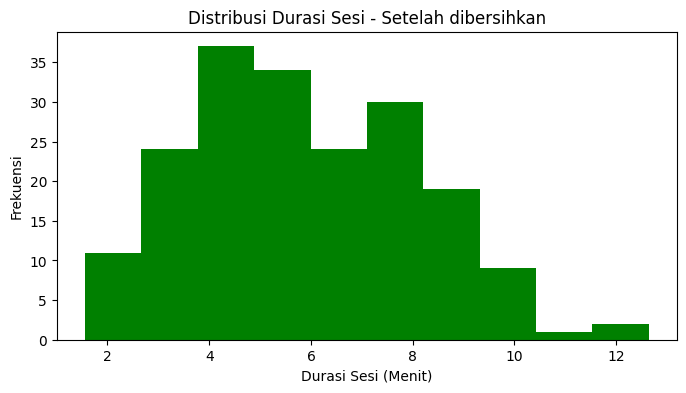

In [20]:
plt.figure(figsize=(8, 4))
plt.hist(df_cleaned['Session_Duration_Minutes'], color='green')
plt.title('Distribusi Durasi Sesi - Setelah dibersihkan')
plt.xlabel('Durasi Sesi (Menit)')
plt.ylabel('Frekuensi')
plt.savefig('hist_after_cleaning.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='Interface_Group', y='Session_Duration_Minutes', data=df_cleaned)
plt.title('Box Plot Durasi Sesi Berdasarkan Interface Group - Setelah dibersihkan')
plt.xlabel('Interface Group')
plt.ylabel('Session Duration (Minutes)')
plt.savefig('boxplot_after_cleaning.svg', format='svg')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Interface_Group', y='Session_Duration_Minutes', data=df_cleaned, errorbar=None)
plt.title('Rata-Rata Durasi Sesi Berdasarkan Interface Group - Setelah dibersihkan')
plt.xlabel('Interface Group')
plt.ylabel('Average Session Duration (Minutes)')
plt.savefig('barplot_after_cleaning.svg', format='svg')
plt.show()

##COMPARISON TEST

Melakukan pemisahan data menjadi dua kelompok berdasarkan kolom Interface_Group untuk t-test.

In [ ]:
versi_a = df_cleaned[df_cleaned['Interface_Group'] == 'Versi A']['Session_Duration_Minutes']
versi_b = df_cleaned[df_cleaned['Interface_Group'] == 'Versi B']['Session_Duration_Minutes']

versi_a.describe()

In [ ]:
versi_b.describe()

Melakukan t-test independen untuk membandingkan rata-rata dua sampel independen untuk menentukan apakah ada perbedaan yang signifikan secara statistik antara kedua kelompok data.


In [ ]:
ttest = stats.ttest_ind(versi_a, versi_b)
print(ttest)

In [ ]:
t_stat, p_val = ttest
print(f"t-Statistic: {t_stat:.5f}")
print(f"p-Value: {p_val:.10f}")

Mengambil kesimpulan hipotesis berdasarkan p-value dan tingkat signifikansi.

In [ ]:
alpha = 0.05
if p_value < alpha:
    print("Conclusion: Reject the null hypothesis...")
else:
    print("Conclusion: Fail to reject the null hypothesis...")

#Eksplanasi
Berdasarkan hasil t-test ditemukan:
- t-Statistic: -13.35404 Nilai t-statistik yang sangat besar (secara absolut) dan negatif menunjukkan adanya perbedaan yang sangat signifikan antara rata-rata durasi sesi kedua kelompok. Tanda negatif secara spesifik mengindikasikan bahwa rata-rata durasi sesi kelompok yang diwakili oleh versi_b (Versi B) lebih tinggi dibandingkan dengan kelompok versi_a (Versi A).
- p-Value: 0.0000000000 P-value yang sangat kecil (mendekati nol) ini adalah indikator yang sangat kuat. Dalam pengujian hipotesis, jika p-value lebih kecil dari tingkat signifikansi yang di tetapkan (0.05), kita akan menolak hipotesis nol.

#Kesimpulan
Ada perbedaan yang sangat signifikan secara statistik dalam durasi sesi antara dua kelompok antarmuka (Versi A dan Versi B). Ini berarti perbedaan rata-rata durasi sesi yang diamati sangat kecil kemungkinannya terjadi karena kebetulan semata. Berdasarkan nilai t-statistik, kita bisa menyimpulkan bahwa antarmuka yang 'Versi B' menghasilkan durasi sesi yang secara signifikan lebih lama dibandingkan dengan antarmuka 'Versi A'.

##RESULT VISUALIZATION

Membuat pie chart untuk memvisualisasikan proporsi total durasi sesi antar 'Versi A' dan 'Versi B'.

In [ ]:
data_pie = df_cleaned.groupby('Interface_Group')['Session_Duration_Minutes'].sum()

plt.figure(figsize=(6, 6))
plt.pie(data_pie, labels=data_pie.index, autopct='%1.1f%%')
plt.title('Komparasi Durasi Sesi per Menit')
plt.savefig('piechart_compare_ab.svg', format='svg')
plt.show()

##Insight

Pie chart ini secara visual menguatkan temuan utama: 'Versi B' menyumbang proporsi durasi sesi total yang **secara signifikan lebih besar** dibandingkan 'Versi A'. Ini dengan jelas menunjukkan bahwa secara keseluruhan, pengguna menghabiskan waktu **jauh lebih banyak** di aplikasi ketika disajikan dengan antarmuka 'Versi B'. Temuan ini, yang diperkuat oleh hasil t-test yang sangat signifikan (p-value mendekati nol), secara definitive menjawab pertanyaan manajemen tentang apakah 'Versi B' sukses membuat user bertahan lebih lama. Kekhawatiran awal mengenai kebingungan atau bobot antarmuka 'Versi B' **tidak terbukti** oleh data durasi sesi.

###Rekomendasi untuk CTO (Chief Technology Officer):

- **Validasi Hipotesis Telah Teruji Kuat:** Kekhawatiran Anda bahwa 'Versi B' mungkin membingungkan atau berat **tidak tercermin sama sekali** dalam metrik durasi sesi. Sebaliknya, pengguna justru menghabiskan **waktu yang jauh lebih lama** dengan antarmuka baru ini, menunjukkan peningkatan engagement yang substansial.
- **Rekomendasi Mendesak:** Berdasarkan bukti statistik yang sangat kuat ini, kami merekomendasikan untuk melanjutkan peluncuran 'Versi B' secara penuh dengan keyakinan penuh. Namun, untuk tetap mengatasi potensi isu performa atau kompleksitas, **sangat disarankan** untuk menerapkan monitoring teknis yang **ketat dan berkelanjutan** setelah peluncuran penuh (misalnya, memantau loading times, penggunaan CPU/memori, dan crash rates) untuk memastikan tidak ada dampak negatif tersembunyi yang muncul pada skala yang lebih besar.

###Rekomendasi untuk Head of Design:

- **Konfirmasi Keyakinan dengan Bukti Kuat:** Keyakinan Anda bahwa 'Versi B' jauh lebih engaging **terbukti sangat benar** berdasarkan data durasi sesi dan hasil t-test. Desain baru ini berhasil memicu perilaku pengguna yang lebih lama di aplikasi dengan perbedaan yang signifikan secara statistik.
- **Rekomendasi Strategis:** Lanjutkan dengan strategi desain yang serupa dengan 'Versi B' dan **segera identifikasi serta dokumentasikan** elemen-elemen desain spesifik mana yang berkontribusi pada peningkatan engagement yang drastis ini. Hal ini **esensial** untuk mengaplikasikan pembelajaran berharga ini pada fitur-fitur dan pengembangan produk di masa depan. Pertimbangkan juga untuk melakukan riset kualitatif (survei, wawancara mendalam) untuk memahami secara mendalam **mengapa** pengguna merasa lebih betah dan berinteraksi lebih lama dengan 'Versi B'.

#FINAL RECOMENDATION
Berdasarkan seluruh analisis yang telah kita lakukan, berikut adalah rekomendasi umum kepada manajemen:

- Rekomendasi Final: **Peluncuran Penuh 'Versi B' Sangat Direkomendasikan**

Analisis data menunjukkan bahwa antarmuka baru 'Versi B' secara signifikan lebih berhasil dalam meningkatkan durasi sesi pengguna dibandingkan dengan antarmuka lama 'Versi A'.

###Langkah Selanjutnya:

Meskipun durasi sesi adalah indikator kunci engagement, kami merekomendasikan untuk juga:

- **Memantau Metrik KPI Lain:** Sebelum peluncuran penuh ke seluruh dunia, pastikan untuk menganalisis metrik penting lainnya seperti tingkat konversi, bounce rate, kepuasan pengguna (melalui survei atau feedback), dan metrik teknis (kecepatan, stabilitas). Hal ini untuk memastikan bahwa peningkatan durasi sesi tidak datang dengan mengorbankan aspek lain dari pengalaman pengguna atau tujuan bisnis.
- **Rencana Peluncuran Bertahap:** Pertimbangkan peluncuran bertahap ke segmen pengguna yang lebih luas untuk memvalidasi temuan ini pada skala yang lebih besar dan mengidentifikasi masalah yang mungkin muncul sebelum peluncuran global.

